## Create training/testing list

In [2]:
import sqlite3, csv, os
from datetime import datetime
from sklearn import datasets
from numpy import genfromtxt
import numpy as np
import time
from scipy.spatial.distance import cdist, pdist
#from sklearn import preprocessing
import matplotlib.pyplot as plt
#from matplotlib.colors import ListedColormap
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
# from unsupervised_alt import *
from __future__ import division
import random
from sklearn import metrics
import pandas as pd
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from sklearn import preprocessing
import scipy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [31]:
input_dir = '/home/lun5/ADH/input'
im_names = []
folder_names = []
labels = []
with open(os.path.join(input_dir,'Jeff_annotations_ADHAllSets.csv'),'rb') as f:
    f_dict = csv.DictReader(f)
    for row in f_dict:
        im_names.append(row['Image'])
        folder_names.append(row['FolderName'])
        labels.append(row['Score'])

In [32]:
print(set(labels))
print(len(set(folder_names)))

set(['Normal Duct', 'skipped', 'Other', 'Columnar', "Don't know", 'ADH', 'Flat Epithelial'])
94


In [131]:
for label in set(labels):
    num_im = np.sum(np.array([labels[j] == label for j in xrange(len(labels))]))
    print('Label %s has %d images' %(label, num_im))

Label Normal Duct has 812 images
Label skipped has 12 images
Label Other has 150 images
Label Columnar has 287 images
Label Don't know has 128 images
Label ADH has 190 images
Label Flat Epithelial has 180 images


In [133]:
import shutil
np.random.seed(10)
sample_indx = []
if not os.path.isdir(os.path.join(input_dir,'sample')):
    os.makedirs(os.path.join(input_dir,'sample'))
for label in ['Normal Duct', 'Columnar', 'Flat Epithelial', 'ADH']:
    indx_label = np.nonzero([labels[j] == label for j in xrange(len(labels))])[0]
    indx_label = np.random.permutation(indx_label)[:12]
    dstdir = os.path.join(input_dir,'sample_indx',label.replace(' ','_'))
    if not os.path.isdir(dstdir):
        os.makedirs(dstdir)
    print([im_names[i] for i in indx_label])
    for j in indx_label:
        shutil.copy(os.path.join(input_dir,folder_names[j],im_names[j].replace(
                    '.jpg','_boundary_2ndPass.jpg')), dstdir)

# sample_indx = np.hstack(sample_indx)
# [im_names[j] for j in sample_indx]

['adh33-1b_seg54.jpg', 'adh29-2b_seg6.jpg', 'adh23-2b_seg14.jpg', 'adh30-1a_seg58.jpg', 'adh38-1a_seg46.jpg', 'adh08-1b_seg35.jpg', 'adh17-1b_seg12.jpg', 'adh23-2b_seg134.jpg', 'adh13-1a_seg3.jpg', 'adh37-1c_seg63.jpg', 'adh24-1b_seg56.jpg', 'adh30-1b_seg67.jpg']
['adh22-2b_seg14.jpg', 'adh23-1a_seg98.jpg', 'adh37-4b_seg77.jpg', 'adh30-1c_seg94.jpg', 'adh37-1a_seg77.jpg', 'adh19-1b_seg16.jpg', 'adh27-2c_seg1.jpg', 'adh10-1b_seg13.jpg', 'adh29-2a_seg26.jpg', 'adh23-1a_seg29.jpg', 'adh08-1a_seg35.jpg', 'adh29-2a_seg12.jpg']
['adh33-1b_seg13.jpg', 'adh15-1a_seg13.jpg', 'adh39-1d_seg101.jpg', 'adh31-1c_seg11.jpg', 'adh04-1a_seg3.jpg', 'adh31-1e_seg17.jpg', 'adh33-1b_seg50.jpg', 'adh39-1d_seg66.jpg', 'adh05-1a_seg37.jpg', 'adh47-1a_seg41.jpg', 'adh23-1a_seg13.jpg', 'adh31-1e_seg38.jpg']
['adh43-2c_seg4.jpg', 'adh17-1b_seg23.jpg', 'adh19-1a_seg37.jpg', 'adh37-1c_seg64.jpg', 'adh31-1c_seg1.jpg', 'adh23-1a_seg89.jpg', 'adh29-2a_seg36.jpg', 'adh37-3a_seg18.jpg', 'adh31-1b_seg4.jpg', 'adh29-2a_s

In [134]:
folder_classes = []
for folder in list(set(folder_names)):
    current_folder = []
    for label in ['Normal Duct', 'Columnar', 'Flat Epithelial', 'ADH']:
        num_im = np.sum(np.array([(folder_names[j] == folder) and 
                                  (labels[j] == label) for j in xrange(len(labels))]))
        current_folder.append(num_im)
    folder_classes.append(np.array(current_folder))
        #print('Folder %s, label %s has %d images' %(folder, label, num_im))
    #print('\n')
folder_classes = np.vstack(folder_classes[:])

In [164]:
np.random.seed(41) # 10
indx = np.random.permutation(np.arange(len(set(folder_names))))
shuffle_folder_classes = folder_classes[indx,:]
np.sum(shuffle_folder_classes[:17,:], axis = 0)
#np.sum(folder_classes[:17,:], axis = 0)

array([115,  71,  30,  48])

In [159]:
np.sum(shuffle_folder_classes[80:89,:],axis = 0)

array([87, 18, 23, 19])

In [160]:
test_list = [list(set(folder_names))[j] for j in indx[:17]]
val_list = [list(set(folder_names))[j] for j in indx[80:89]]
train_indx = np.hstack([indx[17:80],indx[89:]])
train_list = [list(set(folder_names))[j] for j in train_indx]

In [161]:
print(train_list)

['adh39-1d', 'adh39-1a', 'adh37-3b', 'adh04-1a', 'adh42-1b', 'adh11-1a', 'adh30-1a', 'adh19-1b', 'adh32-1b', 'adh31-1c', 'adh24-1a', 'adh07-1b', 'adh26-1a', 'adh29-2b', 'adh43-1a', 'adh05-1a', 'adh45-3a', 'adh07-1a', 'adh04-1e', 'adh37-1a', 'adh29-3a', 'adh16-1a', 'adh24-1c', 'adh19-2a', 'adh03-2a', 'adh39-1b', 'adh42-1a', 'adh24-1b', 'adh13-1a', 'adh38-1a', 'adh08-1a', 'adh46-2a', 'adh46-2b', 'adh37-1e', 'adh36-1d', 'adh37-1c', 'adh37-1b', 'adh04-1c', 'adh30-1c', 'adh37-1d', 'adh43-2c', 'adh31-1e', 'adh20-1a', 'adh44-1a', 'adh21-1a', 'adh48-1a', 'adh23-1a', 'adh34-1a', 'adh40-1b', 'adh23-3a', 'adh41-1a', 'adh35-1a', 'adh27-2c', 'adh14-1a', 'adh37-4b', 'adh12-1b', 'adh33-1b', 'adh06-1b', 'adh07-1c', 'adh18-1a', 'adh10-1c', 'adh27-1a', 'adh10-1b', 'adh22-2b', 'adh19-1a', 'adh37-4a', 'adh36-1a', 'adh22-2a']


In [162]:
test_classes = []
for folder in test_list:
    current_folder = []
    for label in ['Normal Duct', 'Columnar',  'Flat Epithelial','ADH']:
        num_im = np.sum(np.array([(folder_names[j] == folder) and 
                                  (labels[j] == label) for j in xrange(len(labels))]))
        current_folder.append(num_im)
    test_classes.append(np.array(current_folder))

test_classes = np.vstack(test_classes)
np.sum(test_classes, axis = 0)

array([163,  49,  36,  25])

In [167]:
#curr_list = train_list
#curr_list = val_list
curr_list = test_list
mask_dir = 'masked_images'
list_label = []
for folder in curr_list:
    curr_list_label = []
    for label in ['Normal Duct', 'Columnar', 'ADH', 'Flat Epithelial']:
        curr_indx = np.nonzero(np.array([folder_names[j] == folder and
                             (labels[j] == label) for j in xrange(len(labels))]))[0]
        if len(curr_indx) > 0:
            for j in curr_indx:
                fname = os.path.join(input_dir,mask_dir,im_names[j].replace('.','_boundary_2ndPass_normalized_masked.'))
                if os.path.isfile(fname):
                    curr_list_label.append((os.path.join(
                            mask_dir,im_names[j].replace('.','_boundary_2ndPass_normalized_masked.')),label.replace(' ','_')))
            #curr_list_label.append([(os.path.join(
            #                mask_dir,im_names[j].replace('.','_boundary_2ndPass_normalized_masked.')),label.replace(' ','_'))
            #                   for j in curr_indx])
    #list_label.append(sum(curr_list_label[:],[]))
    list_label.append(curr_list_label)

list_label = sum(list_label[:],[])
print(len(list_label))

#with open(os.path.join(input_dir,'train_cs.txt'),'w') as fp:
#with open(os.path.join(input_dir,'val_cs.txt'),'w') as fp:
with open(os.path.join(input_dir,'test_cs.txt'),'w') as fp:
     fp.write('\n'.join('%s %s' %x for x in list_label))

268


In [2]:
from PIL import Image

In [67]:
image_sizes = []
non_exist_images = []
for i in xrange(len(im_names)):
    fname = os.path.join(input_dir,mask_dir,im_names[i].replace('.','_boundary_2ndPass_normalized_masked.'))
    if os.path.isfile(fname):
        im = Image.open(fname)
        image_sizes.append(im.size)
    else:
        non_exist_images.append(im_names[i])

In [68]:
non_exist_images

['adh03-2a_seg53.jpg',
 'adh06-1b_seg48.jpg',
 'adh08-1b_seg35.jpg',
 'adh13-3b_seg8.jpg',
 'adh18-1c_seg9.jpg',
 'adh18-1c_seg22.jpg',
 'adh19-1a_seg18.jpg',
 'adh19-1a_seg28.jpg',
 'adh25-1a_seg70.jpg',
 'adh29-2a_seg52.jpg',
 'adh37-4b_seg28.jpg',
 'adh45-4c_seg78.jpg',
 'adh48-1a_seg19.jpg']

In [70]:
len(image_sizes)

1746

## Classification using PMI features

In [3]:
labelmap = {'Normal_Duct':0, 'Columnar':1, 'ADH':2, 'Flat_Epithelial':3}
n_classes = len(labelmap)

def read_data_list(input_path, list_fname):
    """
    Read <train_data_dir>/TRAIN which containing paths and labels in
    the format label, channel1 file, channel2 file, channel3 
    Returns:
        List with all filenames in file image_list_file
    """
    image_list_file = os.path.join(input_path,list_fname)
    f = open(image_list_file, 'r') #this can read files from the cloud
    filenames = []
    data = []
    labels = []
    n_classes = len(labelmap)
    for line in f:
        fname, label = line.rstrip().split(' ')
        fname = fname.replace('_original.jpg', '_PMIfeatures.mat')
        mat_dict = scipy.io.loadmat(os.path.join(input_path, fname))
        data.append(mat_dict['features'])
        #convert labels into onehot encoding
        onehot = np.zeros(n_classes)
        onehot[labelmap[label]] = 1.0
        labels.append(onehot)
        #create absolute paths for image files
        filenames.append(os.path.join(input_path, fname))
    
    data = np.vstack(data)
    labels = np.vstack(labels)
    return data, labels, filenames, n_classes

In [6]:
input_dir = '/home/lun5/ADH/input'
# read train/val list, # load up the PMI features
X_train, y_train, _, _ = read_data_list(input_dir,'train.txt')
X_val, y_val,_,_ = read_data_list(input_dir,'val.txt')
X_test, y_test,_,_ = read_data_list(input_dir,'test.txt')

NameError: name 'read_data_list' is not defined

In [5]:
# binary
def toBin(labels):
    coded_labels = np.argmax(labels,axis = 1)
    return np.array([int(coded_labels[i] >1) for i in xrange(len(coded_labels))])

toBin(y_test)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [471]:
# read the input 
input_dir = '/home/lun5/ADH/input_Feb16'
feature_fnames = ['ADHFeatures_maxCooc10_k90_onlynuclei.xls',
                  'ADHFeatures_maxCooc10_k95.xls',
                  'ADHFeatures_maxCooc10_k90.xls',
                  'ADHFeatures_maxCooc5_k90.xls',
                  'ADHFeatures_maxCooc10_k95_onlynuclei.xls',
                  'ADHFeatures_maxCooc5_k95.xls']

gt_fname = 'ADH_annotation.csv'
gt = pd.read_csv(os.path.join(input_dir,gt_fname))
gt.columns = ['Participant.1','Image', 'Score.1', 'FolderName',
             'Participant.2','Score.2','Participant.3','Score.3']
#gt = gt.loc[gt['Score.1'].isin(['ADH','Flat Epithelial', 'Columnar', 'Normal Duct']) ,:].loc[
#    gt['Score.1'].isin(['ADH','Flat Epithelial', 'Columnar', 'Normal Duct']) ,:]
a = list(gt['Score.1'])
b = list(gt['Score.2'])
c = list(gt['Score.3'])
gt.loc[:,('Consensus')] = pd.Series(np.asarray([((a[i] == b[i]) or (a[i]==c[i])) or (b[i] == c[i])
                                             for i in xrange(len(a))]), index= reduced_gt.index)
gt.loc[:,('ConsensusLabel')] = pd.Series([mode([a[i],b[i],c[i]])[0][0] for i in xrange(len(a))], 
                                             index=reduced_gt.index)

In [472]:
accepted_labels = ['ADH','Flat Epithelial', 'Columnar', 'Normal Duct',"Don't know",'Other']
reduced_gt = gt.loc[gt['Score.1'].isin(accepted_labels) & gt[
    'Score.2'].isin(accepted_labels) & gt['Score.3'].isin(accepted_labels),:]
#reduced_gt = gt

In [473]:
a = list(reduced_gt['Score.1'])
b = list(reduced_gt['Score.2'])
c = list(reduced_gt['Score.3'])
reduced_gt.loc[:,('Consensus')] = pd.Series(np.asarray([((a[i] == b[i]) or (a[i]==c[i])) or (b[i] == c[i])
                                             for i in xrange(len(a))]), index= reduced_gt.index)
reduced_gt.loc[:,('ConsensusLabel')] = pd.Series([mode([a[i],b[i],c[i]])[0][0] for i in xrange(len(a))], 
                                             index=reduced_gt.index)

In [474]:
accepted_labels = ['ADH','Flat Epithelial', 'Columnar', 'Normal Duct']
reduced_gt = reduced_gt.loc[reduced_gt['ConsensusLabel'].isin(accepted_labels),:]
reduced_gt.to_csv(os.path.join(input_dir,'data_concensus_v2.csv'))

In [475]:
index_conc_by_classes = [np.random.permutation(np.nonzero(reduced_gt['ConsensusLabel'].isin([label]) & 
                                    reduced_gt['Consensus'].isin([True]))[0]) for label in accepted_labels]
                         
print([len(a) for a in index_conc_by_classes])
index_test = [a[:np.minimum(len(a),50)] for a in index_conc_by_classes]
print([len(a) for a in index_test])
index_test = np.hstack(index_test)
test_gt = reduced_gt.iloc[index_test,:]
test_gt.to_csv(os.path.join(input_dir,'test_concensus_v2.csv'))
index_train = np.delete(xrange(len(reduced_gt)), index_test)
train_gt = reduced_gt.iloc[index_train,:]
train_gt.to_csv(os.path.join(input_dir,'train_concensus_v2.csv'))

[35, 36, 107, 427]
[35, 36, 50, 50]


In [29]:
data = pd.read_excel(os.path.join(input_dir, feature_fnames[0]))
data['Image'] = [str(a)[1:-1] for a in list(data.index)]
data.index = xrange(len(data))
data_label_indx = [list(gt.Image).index(a) for a in list(data.Image)]

In [551]:
len(gt)

1759

In [497]:
def read_data(input_dir, feature_fname, gt):
    data = pd.read_excel(os.path.join(input_dir, feature_fname))
    data['imageName'] = [str(a)[1:-1] for a in list(data.imageName)]
    data_label_indx = [list(reduced_gt.Image).index(a) for a in list(data.imageName)]
    data['Score.1'] = gt.iloc[data_label_indx]['Score.1'].as_matrix()
    data['Score.2'] = gt.iloc[data_label_indx]['Score.2'].as_matrix()
    data['Score.3'] = gt.iloc[data_label_indx]['Score.3'].as_matrix()
    data['ConsensusLabel'] = gt.iloc[data_label_indx]['ConsensusLabel'].as_matrix()

    train_indx = data['train/test'].isin([1])
    test_indx = data['train/test'].isin([0])
    X_train = data.loc[train_indx, data.columns[2:-4]].as_matrix()
    X_test =  data.loc[test_indx, data.columns[2:-4]].as_matrix()

    X_train = np.nan_to_num(X_train)
    X_test = np.nan_to_num(X_test)
    y_test = dict()
    y_test[1] = data.loc[test_indx,'ConsensusLabel'].as_matrix()

    y_train = dict()
    y_train[1] = data.loc[train_indx,'Score.1'].as_matrix()
    y_train[2] = data.loc[train_indx,'Score.2'].as_matrix()
    y_train[3] = data.loc[train_indx,'Score.3'].as_matrix()
    
    return X_train, y_train, X_test, y_test

In [498]:
X_train, y_train, X_test, y_test = read_data(input_dir, feature_fnames[1], reduced_gt)

In [500]:
y_train[1]

array(['Normal Duct', 'Normal Duct', 'Normal Duct', 'Normal Duct',
       'Normal Duct', 'Normal Duct', 'Columnar', 'Normal Duct', 'Columnar',
       'Normal Duct', 'Normal Duct', 'Columnar', 'Columnar', 'Columnar',
       'Columnar', 'Normal Duct', 'Normal Duct', 'Normal Duct',
       'Normal Duct', 'Normal Duct', 'Normal Duct', 'Normal Duct',
       'Normal Duct', 'Columnar', 'Normal Duct', 'Normal Duct', 'Columnar',
       'Normal Duct', 'Normal Duct', 'Columnar', 'Normal Duct', 'Columnar',
       "Don't know", 'Normal Duct', 'Columnar', 'Normal Duct', 'Columnar',
       'Normal Duct', 'Normal Duct', 'Columnar', 'Columnar', 'Normal Duct',
       'Normal Duct', 'Normal Duct', 'Columnar', 'Normal Duct',
       'Normal Duct', 'Normal Duct', 'Normal Duct', 'Columnar', 'Columnar',
       'Columnar', 'Normal Duct', 'Normal Duct', 'Normal Duct', 'Columnar',
       'Normal Duct', 'Normal Duct', 'Normal Duct', 'Normal Duct',
       'Normal Duct', 'Normal Duct', 'Normal Duct', 'Normal Duct',


In [494]:
data = pd.read_excel(os.path.join(input_dir, feature_fnames[1]))
data['imageName'] = [str(a)[1:-1] for a in list(data.imageName)]
data_label_indx = [list(reduced_gt.Image).index(a) for a in list(data.imageName)]
data['Score.1'] = reduced_gt.iloc[data_label_indx]['Score.1'].as_matrix()
data['Score.2'] = reduced_gt.iloc[data_label_indx]['Score.2'].as_matrix()
data['Score.3'] = reduced_gt.iloc[data_label_indx]['Score.3'].as_matrix()
data['ConsensusLabel'] = reduced_gt.iloc[data_label_indx]['ConsensusLabel'].as_matrix()

train_indx = data['train/test'].isin([1])
test_indx = data['train/test'].isin([0])
X_train = data.loc[train_indx, data.columns[2:]].as_matrix()
X_test =  data.loc[test_indx, data.columns[2:]].as_matrix()

X_train = np.nan_to_num(X_train)
X_test = np.nan_to_num(X_test)
y_test = dict()
y_test[1] = data.loc[test_indx,'ConsensusLabel'].as_matrix()

y_train = dict()
y_train[1] = data.loc[train_indx,'Score.1'].as_matrix()
y_train[2] = data.loc[train_indx,'Score.2'].as_matrix()
y_train[3] = data.loc[train_indx,'Score.3'].as_matrix()

In [202]:
# preprocessing data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [400]:
X_train, y_train, X_test, y_test = read_data(input_dir, feature_fnames[0], gt)

## Random forest

### Binary

In [417]:
X_train, y_train, X_test, y_test = read_data(input_dir, feature_fnames[0], gt)
ADH_map = {0:0, 1:0, 2:0, 3:1}
y_train = [ADH_map[a] for a in y_train]
y_test = [ADH_map[a] for a in y_test]
#malig_map = {0:0, 1:0, 2:1, 3:1}
#y_train = [malig_map[a] for a in y_train]
#y_test = [malig_map[a] for a in y_test]

In [22]:
olga_score = gt['Score.3']
print([{a:sum(olga_score == a)} for a in ['ADH', 'Columnar', 'Flat Epithelial', 'Normal Duct', 'Other', "Don't know"]])
jeff_score = gt['Score.1']
print([{a:sum(jeff_score == a)} for a in ['ADH', 'Columnar', 'Flat Epithelial', 'Normal Duct', 'Other', "Don't know"]])

[{'ADH': 28}, {'Columnar': 223}, {'Flat Epithelial': 136}, {'Normal Duct': 1134}, {'Other': 162}, {"Don't know": 76}]
[{'ADH': 190}, {'Columnar': 287}, {'Flat Epithelial': 180}, {'Normal Duct': 812}, {'Other': 150}, {"Don't know": 128}]


In [208]:
# build cross validation to find the optimal settings for parameters
def RF_classifier(X_train, y_train, X_test, y_test):
    tuned_parameters = [{'n_estimators':[2, 10, 50, 100], 
                        'max_features':['auto','log2'],
                        'max_depth':[5,10,None],
                       'class_weight':['balanced','balanced_subsample']}]

    scores = ['f1','precision','recall']
    scores = ['recall']
    for score in scores:
        print('Tuning parameter for %s' %score)
        print()

        clf = GridSearchCV(RandomForestClassifier(n_estimators=10),tuned_parameters,
                           cv = 6, scoring= '%s_macro' %score, n_jobs = 5)
        #clf.fit(X_train,toBin(y_train))
        clf.fit(X_train,y_train)
        #clf.fit(np.vstack([X_train,X_val]),toBin(np.vstack([y_train,y_val])))
        print("Best parameters set found on development set:")
        print()
        print(clf.best_params_)
        best_params = clf.best_params_
        print()
        #print("Grid scores on development set:")
        #print()
        #means = clf.cv_results_['mean_test_score']
        #stds = clf.cv_results_['std_test_score']
        #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        #    print("%0.3f (+/-%0.03f) for %r"
        #          % (mean, std * 2, params))
        #print()

        print("Detailed classification report:")
        print()
        print("The model is trained on the full development set.")
        print("Training result")
        y_true, y_pred = y_train, clf.predict(X_train)
        #y_true, y_pred = toBin(y_val), clf.predict(X_val)
        print(classification_report(y_true, y_pred))
        print('Accuracy = ', metrics.accuracy_score(y_true,y_pred))

        print("The scores are computed on the full evaluation set.")
        print()
        #y_true, y_pred = toBin(y_test), clf.predict(X_test)
        y_true, y_pred = y_test, clf.predict(X_test)
        #y_true, y_pred = toBin(y_val), clf.predict(X_val)
        print(classification_report(y_true, y_pred))
        print('Accuracy = ', metrics.accuracy_score(y_true,y_pred))

In [48]:
feature_fnames

['ADHFeatures_maxCooc10_k90_onlynuclei.xls',
 'ADHFeatures_maxCooc10_k95.xls',
 'ADHFeatures_maxCooc10_k90.xls',
 'ADHFeatures_maxCooc5_k90.xls',
 'ADHFeatures_maxCooc10_k95_onlynuclei.xls',
 'ADHFeatures_maxCooc5_k95.xls']

In [9]:
from itertools import product

In [209]:
ADH_map = {'Normal Duct':0, 'Columnar':0, 'Flat Epithelial':0, 'ADH':1}
malig_map = {'Normal Duct':0, 'Columnar':0, 'Flat Epithelial':1, 'ADH':1}

for i in xrange(len(feature_fnames)):
    print(feature_fnames[i])
    X_train, y_train, X_test, y_test = read_data(input_dir, feature_fnames[i], gt)
    for dict_map in [ADH_map, malig_map]:
        print(dict_map)
        #for j,k in product([1,2],[1,2]):
        for j,k in zip([1],[1]):
            print('Train on P', str(j), '. Test on P', str(k))
            y_train_new = [dict_map[a] for a in y_train[j]]
            y_test_new = [dict_map[b] for b in y_test[k]]
            RF_classifier(X_train, y_train_new, X_test, y_test_new)

ADHFeatures_maxCooc10_k90_onlynuclei.xls
{'Normal Duct': 0, 'Columnar': 0, 'ADH': 1, 'Flat Epithelial': 0}
Train on P 1 . Test on P 1
Tuning parameter for recall

Best parameters set found on development set:

{'max_features': 'log2', 'n_estimators': 10, 'max_depth': 5, 'class_weight': 'balanced_subsample'}

Detailed classification report:

The model is trained on the full development set.
Training result
             precision    recall  f1-score   support

          0       0.94      0.66      0.78      1022
          1       0.24      0.74      0.36       152

avg / total       0.85      0.67      0.72      1174

Accuracy =  0.667802385009
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.89      0.67      0.77       257
          1       0.16      0.42      0.23        38

avg / total       0.79      0.64      0.70       295

Accuracy =  0.640677966102
{'Normal Duct': 0, 'Columnar': 0, 'ADH': 1, 'Flat Epit

In [422]:
#{'max_features': 'auto', 'n_estimators': 10, 'max_depth': 10, 'class_weight': 'balanced_subsample'}
clf = RandomForestClassifier(n_estimators=best_params['n_estimators'], max_features=best_params['max_features'],
                            max_depth=best_params['max_depth'],class_weight=best_params['class_weight'])
clf.fit(X_train,y_train)
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print(metrics.accuracy_score(y_true,y_pred))

             precision    recall  f1-score   support

          0       0.89      0.71      0.79       257
          1       0.18      0.42      0.25        38

avg / total       0.80      0.67      0.72       295

0.671186440678


In [113]:
print('y_true is ',y_true, ' y_pred is ', y_pred)
print('accuracy is ', metrics.accuracy_score(y_true, y_pred))

y_true is  [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0]  y_pred is  [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0
 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1
 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1
 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 

In [110]:
clf = RandomForestClassifier(n_estimators=10, max_features='auto',
                            max_depth=5,class_weight='balanced_subsample')
clf.fit(np.vstack([X_train,X_val]),toBin(np.vstack([y_train,y_val])))
y_true, y_pred = toBin(y_test), clf.predict(X_test)
print(classification_report(y_true, y_pred))
print(metrics.accuracy_score(y_true,y_pred))

             precision    recall  f1-score   support

          0       0.81      0.78      0.80       216
          1       0.16      0.19      0.17        48

avg / total       0.69      0.67      0.68       264

0.674242424242


### 4-way

In [401]:
X_train, y_train, X_test, y_test = read_data(input_dir, feature_fnames[0], gt)

In [402]:
# build cross validation to find the optimal settings for parameters
tuned_parameters = [{'n_estimators':[2, 10, 50, 100], 
                    'max_features':['auto','log2'],
                    'max_depth':[5,10,None],
                   'class_weight':['balanced','balanced_subsample']}]

scores = ['f1','precision','recall']

for score in scores:
    print('Tuning parameter for %s' %score)
    print()
    
    clf = GridSearchCV(RandomForestClassifier(n_estimators=10),tuned_parameters,
                       cv = 5, scoring= '%s_macro' %score, n_jobs = 5)
    clf.fit(X_train,y_train)
    #clf.fit(np.vstack([X_train,X_val]),np.vstack([y_train,y_val]))

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    #print("Grid scores on development set:")
    #print()
    #means = clf.cv_results_['mean_test_score']
    #stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #    print("%0.3f (+/-%0.03f) for %r"
    #          % (mean, std * 2, params))
    #print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    #y_true, y_pred = y_val, clf.predict(X_val)
    print(classification_report(y_true, y_pred))
    print()

Tuning parameter for f1



/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:

{'max_features': 'log2', 'n_estimators': 50, 'max_depth': 10, 'class_weight': 'balanced_subsample'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.61      0.57      0.59       163
          1       0.22      0.14      0.17        58
          2       0.10      0.17      0.12        36
          3       0.17      0.21      0.19        38

avg / total       0.42      0.39      0.40       295


Tuning parameter for precision



/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:

{'max_features': 'auto', 'n_estimators': 10, 'max_depth': 10, 'class_weight': 'balanced_subsample'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.64      0.64      0.64       163
          1       0.26      0.16      0.20        58
          2       0.12      0.17      0.14        36
          3       0.24      0.29      0.27        38

avg / total       0.45      0.44      0.44       295


Tuning parameter for recall

Best parameters set found on development set:

{'max_features': 'log2', 'n_estimators': 2, 'max_depth': 10, 'class_weight': 'balanced'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.62      0.47      

In [404]:
#{'max_features': 'auto', 'n_estimators': 10, 'max_depth': 10, 'class_weight': 'balanced_subsample'}
clf = RandomForestClassifier(n_estimators=10, max_features='auto',
                            max_depth=10,class_weight='balanced_subsample')
#clf.fit(np.vstack([X_train,X_val]),np.vstack([y_train,y_val]))
clf.fit(X_train,y_train)
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print(metrics.accuracy_score(y_true,y_pred))

             precision    recall  f1-score   support

          0       0.61      0.62      0.62       163
          1       0.19      0.10      0.13        58
          2       0.16      0.25      0.20        36
          3       0.19      0.21      0.20        38

avg / total       0.42      0.42      0.42       295

0.420338983051


In [106]:
clf = RandomForestClassifier(n_estimators=50, max_features='auto',
                            max_depth=None,class_weight='balanced')
clf.fit(np.vstack([X_train,X_val]),np.vstack([y_train,y_val]))
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))
print(metrics.accuracy_score(y_true,y_pred))

             precision    recall  f1-score   support

          0       0.50      0.73      0.59       115
          1       0.14      0.01      0.03        71
          2       0.00      0.00      0.00        30
          3       0.50      0.04      0.08        48

avg / total       0.35      0.33      0.28       264

0.329545454545


## SVC

### Binary

In [111]:
from sklearn.svm import SVC
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100]}]
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3,1e-4],
#                      'C': [1, 100,1000]}]

scores = ['precision', 'recall']

for score in scores:
    print('Tuning parameter for %s' %score)
    print()
    
    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=3,
                       scoring='%s_macro' % score,n_jobs = 4)
    
    clf.fit(X_train,toBin(y_train))
    
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    #print("Grid scores on development set:")
    #print()
    #means = clf.cv_results_['mean_test_score']
    #stds = clf.cv_results_['std_test_score']
    #for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    #    print("%0.3f (+/-%0.03f) for %r"
    #          % (mean, std * 2, params))
    #print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = toBin(y_test), clf.predict(X_test)
    #y_true, y_pred = toBin(y_val), clf.predict(X_val)
    print(classification_report(y_true, y_pred))
    print()

Tuning parameter for precision



/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

Best parameters set found on development set:

{'kernel': 'rbf', 'C': 1, 'gamma': 0.001}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.82      1.00      0.90       216
          1       0.00      0.00      0.00        48

avg / total       0.67      0.82      0.74       264


Tuning parameter for recall



/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:

{'kernel': 'rbf', 'C': 1, 'gamma': 0.001}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.82      1.00      0.90       216
          1       0.00      0.00      0.00        48

avg / total       0.67      0.82      0.74       264




In [8]:
clf = SVC(kernel='rbf',gamma=1e-4, C=10)
clf.fit(np.vstack([X_train,X_val]),toBin(np.vstack([y_train,y_val])))
y_true, y_pred = toBin(y_test), clf.predict(X_test)
print(classification_report(y_true, y_pred))
print(metrics.accuracy_score(y_true,y_pred))

             precision    recall  f1-score   support

          0       0.70      0.99      0.82       186
          1       0.33      0.01      0.02        78

avg / total       0.60      0.70      0.59       264



NameError: name 'metrics' is not defined

### 4-way

In [9]:
from sklearn.svm import SVC
# tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
#                      'C': [1, 10, 100, 1000]},
#                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3,1e-4],
                     'C': [1, 100,1000]}]

scores = ['precision', 'recall']

for score in scores:
    print('Tuning parameter for %s' %score)
    print()
    
    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=3,
                       scoring='%s_macro' % score,n_jobs = 8)
    
    clf.fit(X_train,np.argmax(y_train,axis = 1))
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = np.argmax(y_val,axis = 1), clf.predict(X_val)
    print(classification_report(y_true, y_pred))
    print()

Tuning parameter for precision



/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average

Best parameters set found on development set:

{'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}

Grid scores on development set:

0.143 (+/-0.001) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.143 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.411 (+/-0.036) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.439 (+/-0.086) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.424 (+/-0.026) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.413 (+/-0.064) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.67      0.97      0.79        78
          1       0.00      0.00      0.00        15
          2       0.40      0.11      0.17        18
          3       0.20      0.08      0.11        13

avg / total       0.50      0.64      0.53       124


Tuning parameter for rec

/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:

{'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}

Grid scores on development set:

0.250 (+/-0.001) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.001}
0.250 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'gamma': 0.0001}
0.368 (+/-0.038) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.001}
0.328 (+/-0.049) for {'kernel': 'rbf', 'C': 100, 'gamma': 0.0001}
0.401 (+/-0.002) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.001}
0.355 (+/-0.043) for {'kernel': 'rbf', 'C': 1000, 'gamma': 0.0001}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.73      0.85      0.78        78
          1       0.00      0.00      0.00        15
          2       0.14      0.11      0.12        18
          3       0.27      0.31      0.29        13

avg / total       0.50      0.58      0.54       124




In [13]:
clf = SVC(kernel='rbf',gamma=1e-3, C=100)
clf.fit(X_train,np.argmax(y_train,axis =1))
y_true, y_pred = np.argmax(y_test,axis=1), clf.predict(X_test)
print(classification_report(y_true, y_pred))

             precision    recall  f1-score   support

          0       0.49      0.90      0.63       115
          1       0.46      0.08      0.14        71
          2       0.30      0.12      0.18        48
          3       0.24      0.13      0.17        30

avg / total       0.42      0.45      0.37       264



## MPL classifer

In [ ]:
from sklearn.neural_network import MLPClassifier
tuned_parameters = [{'hidden_layer_size'= [(100,),(10,)] , 
                     'alpha'=[1e-4,1e-2,1],
                    'learning_rate'=['constant','adaptive']}]

scores = ['precision', 'recall']

for score in scores:
    print('Tuning parameter for %s' %score)
    print()
    
    clf = GridSearchCV(MLPClassifier(alpha=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    
    clf.fit(X_train,np.argmax(y_train,axis = 1))
    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = np.argmax(y_val,axis = 1), clf.predict(X_val)
    print(classification_report(y_true, y_pred))
    print()

##  Classification using color stats 

In [74]:
data_fname = 'PospectorImages_clusterRatios.csv'
data_imnames = []
cs_data = []

with open(os.path.join(input_dir,data_fname)) as f:
    f_csv = csv.DictReader(f)
    feat_indx = np.nonzero([not f_csv.fieldnames[j] in ['FileName'] 
                            for j in xrange(len(f_csv.fieldnames))])[0]
    feat_names = [f_csv.fieldnames[feat_indx[j]] for j in xrange(len(feat_indx))]
    for row in f_csv:
        data_imnames.append(row['FileName'])
        cs_data.append([float(row[feat_names[j]]) for j in xrange(len(feat_indx))])

cs_data = np.vstack(cs_data)


In [75]:
cs_data.shape

(1759, 8)

In [80]:
match_id = [data_imnames[j] == im_names[j].replace('.jpg','') for j in xrange(len(im_names))]

In [86]:
# I will have the match the image name with labels
# data_imlabels = []
# for fname in data_imnames:
#     indx = im_names.index((fname + '.jpg'))
#     data_imlabels.append(labels[indx])
data_imlabels = [labels[im_names.index(fname + '.jpg')] for fname in data_imnames]

In [191]:
labelmap = {'Normal_Duct':0, 'Columnar':1, 'Flat_Epithelial':2, 'ADH':3}
n_classes = len(labelmap)

def read_data_list(input_path, list_fname):
    """
    Read <train_data_dir>/TRAIN which containing paths and labels in
    the format label, channel1 file, channel2 file, channel3 
    Returns:
        List with all filenames in file image_list_file
    """
    image_list_file = os.path.join(input_path,list_fname)
    f = open(image_list_file, 'r') #this can read files from the cloud
    filenames = []
    data = []
    labels = []
    n_classes = len(labelmap)    
    
    for line in f:
        fname, label = line.rstrip().split(' ')
        dir_name, fname = fname.rstrip().split('/')
        indx = data_imnames.index(fname.replace('_boundary_2ndPass_normalized_masked.jpg', ''))
        data.append(cs_data[indx,:])
        #convert labels into onehot encoding
        onehot = np.zeros(n_classes)
        onehot[labelmap[label]] = 1.0
        labels.append(onehot)
        #create absolute paths for image files
        filenames.append(os.path.join(input_path, fname))
    
    data = np.vstack(data)
    labels = np.vstack(labels)
    labels_coded = np.argmax(labels, axis = 1)
    return data, labels, labels_coded

def toBin(labels):
    coded_labels = np.argmax(labels,axis = 1)
    return np.array([int(coded_labels[i] >2) for i in xrange(len(coded_labels))])


In [195]:
input_dir = '/home/lun5/ADH/input'
# read train/val list, # load up the PMI features
X_train, y_train,y_train_coded = read_data_list(input_dir,'train_cs.txt')
X_val, y_val,y_val_coded = read_data_list(input_dir,'val_cs.txt')
X_test, y_test,y_test_coded = read_data_list(input_dir,'test_cs.txt')

In [197]:
population = [np.sum(y_train_coded  == j) for j in xrange(4)]
sample_indices = [np.random.choice(np.nonzero(y_train_coded == i)[0],
                                 size = np.sum(y_train_coded == np.argmin(population)), replace = False)
                  for i in xrange(4)]
sample_indices = np.hstack(sample_indices)
X_train, y_train, y_train_coded = X_train[sample_indices,:],y_train[sample_indices,:],y_train_coded[sample_indices] 
print([np.sum(y_train_coded  == j) for j in xrange(4)])

[132, 132, 132, 132]


In [198]:
population = [np.sum(y_val_coded  == j) for j in xrange(4)]
print(population)
sample_indices = [np.random.choice(np.nonzero(y_val_coded == i)[0],
                                 size = np.sum(y_val_coded == np.argmin(population)),
                                   replace = False)
                  for i in xrange(4)]
sample_indices = np.hstack(sample_indices)
X_val, y_val, y_val_coded = X_val[sample_indices,:],y_val[sample_indices,:],y_val_coded[sample_indices] 
print([np.sum(y_val_coded  == j) for j in xrange(4)])

[86, 18, 23, 19]
[18, 18, 18, 18]


In [199]:
population = [np.sum(y_test_coded  == j) for j in xrange(4)]
print(population)
sample_indices = [np.random.choice(np.nonzero(y_test_coded == i)[0],
                                 size = np.sum(y_test_coded == np.argmin(population)),
                                   replace = False)
                  for i in xrange(4)]
sample_indices = np.hstack(sample_indices)
X_test, y_test, y_test_coded = X_test[sample_indices,:],y_test[sample_indices,:],y_test_coded[sample_indices] 
print([np.sum(y_test_coded  == j) for j in xrange(4)])

[158, 49, 25, 36]
[25, 25, 25, 25]


## Test imbalanced learn

In [42]:
import imblearn
from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

In [44]:
RANDOM_STATE = 42
pipeline = make_pipeline(NearMiss(version=2, random_state=RANDOM_STATE),
                         LinearSVC(random_state=RANDOM_STATE))
pipeline.fit(X_train, y_train_new)

# Classify and report the results
print(classification_report_imbalanced(y_test_new, pipeline.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.27      0.79      0.41      0.35      0.13       257
          1       0.14      0.79      0.27      0.23      0.35      0.11        38

avg / total       0.80      0.34      0.72      0.39      0.35      0.13       295



Automatically created module for IPython interactive environment


/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


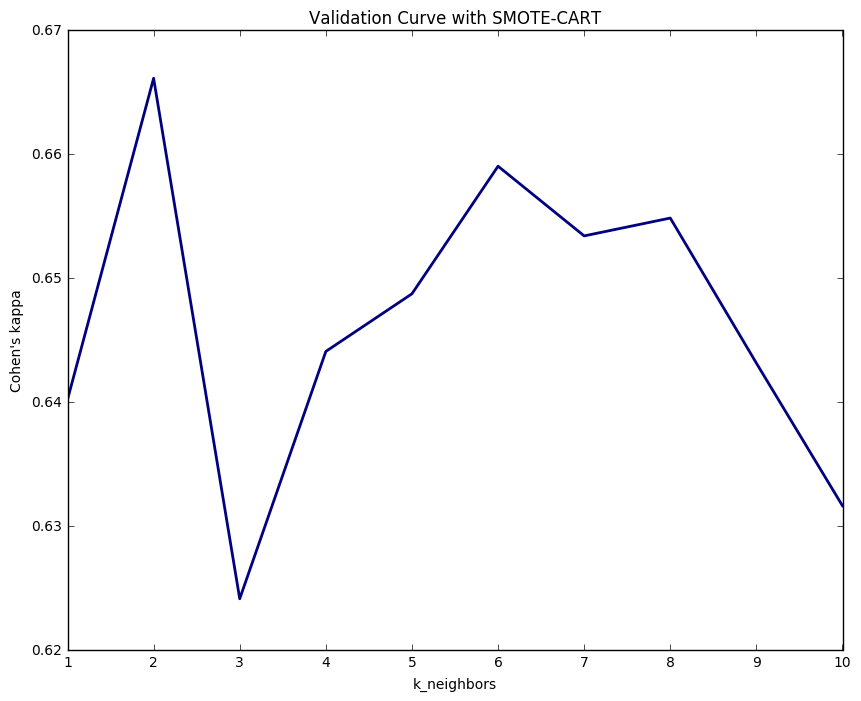

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection as ms
from sklearn import datasets, metrics, tree

from imblearn import over_sampling
from imblearn import pipeline as pl

print(__doc__)

LW = 2
RANDOM_STATE = 42

scorer = metrics.make_scorer(metrics.cohen_kappa_score)

# Generate the dataset
X, y = datasets.make_classification(n_classes=2, class_sep=2,
                                    weights=[0.1, 0.9], n_informative=10,
                                    n_redundant=1, flip_y=0, n_features=20,
                                    n_clusters_per_class=4, n_samples=5000,
                                    random_state=RANDOM_STATE)

smote = over_sampling.SMOTE(random_state=RANDOM_STATE)
cart = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)
pipeline = pl.make_pipeline(smote, cart)

param_range = range(1, 11)
#train_scores, test_scores = ms.validation_curve(
#    pipeline, X, y, param_name="smote__k_neighbors", param_range=param_range,
#    cv=3, scoring=scorer, n_jobs=1)

clf = GridSearchCV(pipeline,param_grid={"smote__k_neighbors":param_range}
                           cv = 6, scoring='%s_macro' %score, n_jobs = 5)
clf.fit(X_train,y_train_new)
print(classification_report_imbalanced(y_test_new, clf.predict(X_test)))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SMOTE-CART")
plt.xlabel("k_neighbors")
plt.ylabel("Cohen's kappa")
plt.plot(param_range, test_scores_mean, color="navy", lw=LW)
plt.legend(loc="best")
plt.show()

In [71]:
np.arange(0.2,1,step=0.2)

array([ 0.2,  0.4,  0.6,  0.8])

In [210]:
for i in xrange(len(feature_fnames)):
    print('feature name: ', feature_fnames[i])
    X_train, y_train, X_test, y_test = read_data(input_dir, feature_fnames[i], gt)
    for dict_map in [ADH_map, malig_map]:
        print(dict_map)
        y_train_new = [dict_map[a] for a in y_train[1]]
        y_test_new = [dict_map[b] for b in y_test[1]]
        score = 'recall'

        tuned_parameters = {'randomforestclassifier__n_estimators':[2, 10, 50, 100], 
                            'randomforestclassifier__max_features':['auto','log2'],
                            'randomforestclassifier__max_depth':[5,10,None],
                           'randomforestclassifier__class_weight':['balanced','balanced_subsample'],
                           'smote__k_neighbors':param_range}#, 'smote__ratio': np.arange(0.2,1,step=0.2)}

        smote = over_sampling.SMOTE(random_state=RANDOM_STATE)
        #cart = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)
        cart = RandomForestClassifier(random_state=RANDOM_STATE)
        pipeline = pl.make_pipeline(smote, cart)

        clf = GridSearchCV(pipeline,param_grid=tuned_parameters,
                               cv = 6, scoring= '%s_macro' %score, n_jobs = 7)
        clf.fit(X_train,y_train_new)
        print(clf.best_params_)
        print('Training result')
        print(classification_report_imbalanced(y_train_new, clf.predict(X_train)))
        print('Accuracy = ', metrics.accuracy_score(y_train_new, clf.predict(X_train)))
        print(classification_report_imbalanced(y_test_new, clf.predict(X_test)))
        print('Accuracy = ', metrics.accuracy_score(y_test_new, clf.predict(X_test)))

feature name:  ADHFeatures_maxCooc10_k90_onlynuclei.xls
{'Normal Duct': 0, 'Columnar': 0, 'ADH': 1, 'Flat Epithelial': 0}
{'randomforestclassifier__class_weight': 'balanced_subsample', 'randomforestclassifier__n_estimators': 10, 'randomforestclassifier__max_depth': 5, 'smote__k_neighbors': 4, 'randomforestclassifier__max_features': 'auto'}
Training result
                   pre       rec       spe        f1       geo       iba       sup

          0       0.95      0.57      0.82      0.71      0.46      0.22      1022
          1       0.22      0.82      0.57      0.35      0.46      0.19       152

avg / total       0.86      0.60      0.78      0.66      0.46      0.22      1174

Accuracy =  0.600511073254
                   pre       rec       spe        f1       geo       iba       sup

          0       0.89      0.60      0.53      0.71      0.38      0.15       257
          1       0.16      0.53      0.60      0.25      0.38      0.13        38

avg / total       0.80      0

## New features

In [58]:
import imblearn
from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

In [59]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import model_selection as ms
from sklearn import datasets, metrics, tree

from imblearn import over_sampling
from imblearn import pipeline as pl
import sklearn
print(__doc__)

LW = 2
RANDOM_STATE = 42

scorer = metrics.make_scorer(metrics.cohen_kappa_score)
input_dir = '/home/lun5/ADH/ADH_features_5phenotypes/'
input_dir = '/home/lun5/ADH/ADH_feature_sets/'

feature_fnames = os.listdir(input_dir)
print(feature_fnames)
ADH_map = {'Normal Duct':0, 'Columnar':0, 'Flat epithelial':0,'Flat Epithelial':0, 'ADH':1}
malig_map = {'Normal Duct':0, 'Columnar':0, 'Flat epithelial':1,'Flat Epithelial':1, 'ADH':1}
fourway_map = {'Normal Duct':0, 'Columnar':1, 'Flat epithelial':2,'Flat Epithelial':2, 'ADH':3}

Automatically created module for IPython interactive environment
['ADHTestFeatures_maxCooc10_k95_ObjectFinal.xls', 'ADHTrainFeatures_maxCooc10_k90_NucleiFinal.xls', 'ADHTestFeatures_maxCooc5_k90_ObjectFinal.xls', 'ADHTestFeatures_nuc_feats_mean_std_zscore.xlsx', 'ADHTrainFeatures_nuc_feats_mean_std.xlsx', 'ADHTestFeatures_maxCooc5_k95_CombinedFinal.xls', 'ADHTrainFeatures_maxCooc5_k95_CombinedFinal.xls', 'ADHTrainFeatures_maxCooc5_k90_5NucleiCombinedFinal.xls', 'ADHTrainFeatures_maxCooc5_k95_5NucleiCombinedFinal.xls', 'ADHTrainFeatures_maxCooc5_k90_NucleiFinal.xls', 'ADHTestFeatures_maxCooc5_k95_ObjectFinal.xls', 'ADHTrainFeatures_maxCooc5_k95_NucleiFinal.xls', 'ADHTrainFeatures_maxCooc5_k90_CombinedFinal.xls', 'ADHTestFeatures_maxCooc5_k90_5NucleiFinal.xls', 'ADHTrainFeatures_nuc_feats_mean_std_zscore.xlsx', 'ADHTrainFeatures_maxCooc5_k95_5NucleiFinal.xls', 'ADHTrainFeatures_maxCooc5_k90_ObjectFinal.xls', 'ADHTestFeatures_maxCooc5_k90_5NucleiCombinedFinal.xls', 'ADHTestFeatures_maxCoo

In [60]:
settings = set(['_'.join(a.split('_')[1:]) for a in feature_fnames])
print(settings)

set(['maxCooc10_k90_NucleiFinal.xls', 'maxCooc5_k90_CombinedFinal.xls', 'maxCooc10_k90_CombinedFinal.xls', 'maxCooc5_k90_5NucleiFinal.xls', 'maxCooc5_k95_ObjectFinal.xls', 'maxCooc5_k95_5NucleiFinal.xls', 'maxCooc5_k90_NucleiFinal.xls', 'maxCooc5_k95_NucleiFinal.xls', 'maxCooc10_k95_CombinedFinal.xls', 'nuc_feats_mean_std_zscore.xlsx', 'maxCooc10_k95_NucleiFinal.xls', 'maxCooc10_k90_ObjectFinal.xls', 'maxCooc5_k90_5NucleiCombinedFinal.xls', 'maxCooc5_k90_ObjectFinal.xls', 'maxCooc5_k95_CombinedFinal.xls', 'maxCooc5_k95_5NucleiCombinedFinal.xls', 'nuc_feats_mean_std.xlsx', 'maxCooc10_k95_ObjectFinal.xls'])


In [75]:
settings = ['maxCooc10_k90_NucleiFinal.xls', 'maxCooc5_k90_CombinedFinal.xls', 
            'maxCooc10_k90_CombinedFinal.xls', 'maxCooc5_k90_5NucleiFinal.xls', 
            'maxCooc5_k95_ObjectFinal.xls', 'maxCooc5_k95_5NucleiFinal.xls', 'maxCooc5_k90_NucleiFinal.xls',
            'maxCooc5_k95_NucleiFinal.xls', 'maxCooc10_k95_CombinedFinal.xls']
accepted_labels = ['ADH','Flat epithelial', 'Columnar', 'Normal Duct']
#settings = ['maxCooc5_k95_5NucleiCombinedFinal.xls']

In [88]:
settings = ['maxCooc10_k95_CombinedFinal.xls']

In [590]:
import sklearn
y_pred_probs = clf.predict_proba(X_test)
print('Accuracy = ', metrics.accuracy_score(y_test, clf.predict(X_test)))
print('roc_auc = ', metrics.roc_auc_score(y_test, clf.predict(X_test)))
thres = np.arange(0,1, 0.1)
for t in thres:
    y_pred = y_pred_probs[:,1] > t
    print('Threshold = ', t)
    print('Accuracy = ', metrics.accuracy_score(y_test, y_pred))
    print('roc_auc = ', metrics.roc_auc_score(y_test, y_pred))
    print(sklearn.metrics.confusion_matrix(y_test, y_pred))

Accuracy =  0.828947368421
roc_auc =  0.533682373473
Threshold =  0.0
Accuracy =  0.626644736842
roc_auc =  0.506831214161
[[368 205]
 [ 22  13]]
Threshold =  0.1
Accuracy =  0.626644736842
roc_auc =  0.506831214161
[[368 205]
 [ 22  13]]
Threshold =  0.2
Accuracy =  0.626644736842
roc_auc =  0.506831214161
[[368 205]
 [ 22  13]]
Threshold =  0.3
Accuracy =  0.626644736842
roc_auc =  0.506831214161
[[368 205]
 [ 22  13]]
Threshold =  0.4
Accuracy =  0.626644736842
roc_auc =  0.506831214161
[[368 205]
 [ 22  13]]
Threshold =  0.5
Accuracy =  0.828947368421
roc_auc =  0.533682373473
[[497  76]
 [ 28   7]]
Threshold =  0.6
Accuracy =  0.828947368421
roc_auc =  0.533682373473
[[497  76]
 [ 28   7]]
Threshold =  0.7
Accuracy =  0.828947368421
roc_auc =  0.533682373473
[[497  76]
 [ 28   7]]
Threshold =  0.8
Accuracy =  0.828947368421
roc_auc =  0.533682373473
[[497  76]
 [ 28   7]]
Threshold =  0.9
Accuracy =  0.828947368421
roc_auc =  0.533682373473
[[497  76]
 [ 28   7]]


In [65]:
train_df.columns

Index([u'Unnamed: 0', u'imagename', u'label', u'feat.0', u'feat.1', u'feat.2',
       u'feat.3', u'feat.4', u'feat.5', u'feat.6',
       ...
       u'feat.386', u'feat.387', u'feat.388', u'feat.389', u'feat.390',
       u'feat.391', u'feat.392', u'feat.393', u'feat.394', u'feat.395'],
      dtype='object', length=399)

In [93]:
param_range = range(1, 15)
for ss in settings:
    train_df = pd.read_excel(os.path.join(input_dir,'ADHTrainFeatures_' + ss))
    #train_df = pd.read_csv(os.path.join(input_dir,'ADHTrainFeatures_' + ss))
    X_train = train_df[train_df.columns[2:]].as_matrix()
    X_train = np.nan_to_num(X_train)
    
    test_df = pd.read_excel(os.path.join(input_dir,'ADHTestFeatures_' + ss))
    #test_df = pd.read_csv(os.path.join(input_dir,'ADHTestFeatures_' + ss))
    X_test = test_df[test_df.columns[2:]].as_matrix()
    X_test = np.nan_to_num(X_test)
    print('\n')
    print(ss, X_train.shape, X_test.shape)
    for dict_map in [malig_map]: #[fourway_map]: 
        print('\n')
        print(dict_map)
        y_train = [dict_map[a] for a in list(train_df['label'])]
        y_test = [dict_map[a] for a in list(test_df['label'])]        
        #scores = ['precision', 'recall','f1']
        #scores = ['accuracy', 'f1_weighted', 'roc_auc']
        scores = ['roc_auc']
        #scores = ['f1_micro', 'f1_macro','f1_weighted','accuracy']#,'cohen_kappa']
        #scorers = [metrics.make_scorer(metrics.f1_score), metrics.scorer(metrics.recall_score),
        #           metrics.make_scorer(metrics.roc_auc_score), metrics.make_scorer(metrics.cohen_kappa_score)]
        #for score,scorer in zip(scores, scorers):
        for score in scores:
            print('\nOptimized for %s' %score)
            #tuned_parameters = {'randomforestclassifier__n_estimators':[25, 50, 100], 
            #                    'randomforestclassifier__max_features':['auto','log2'],
            #                    'randomforestclassifier__max_depth':[5,10,None],
            #                   'smote__k_neighbors':param_range}#, 'smote__ratio': np.arange(0.2,1,step=0.2)}
            
            #smote = over_sampling.SMOTE(random_state=RANDOM_STATE, kind = 'borderline1')
            #cart = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)
            #cart = RandomForestClassifier(random_state=RANDOM_STATE)
            #pipeline = pl.make_pipeline(smote, cart)

            tuned_parameters = {'svc__C': [1e3, 1e4, 1e5], 
                                'svc__gamma': [0.0001, 0.001, 0.01, 0.1],
                                'svc__kernel':['rbf'],
                               'smote__k_neighbors':param_range}#, 'smote__ratio': np.arange(0.2,1,step=0.2)}
            smote = over_sampling.SMOTE(random_state=RANDOM_STATE, kind = 'borderline1')
            cart = sklearn.svm.SVC()
            pipeline = pl.make_pipeline(smote, cart)
            clf = GridSearchCV(pipeline,param_grid=tuned_parameters,
                                   cv = 3, scoring= '%s' %score, n_jobs = 7)
            
            #tuned_parameters = {'C':[1e3,1e4,1e5],
            #                    'gamma':[1e-5,1e-4,1e-2],
            #                   'kernel':['rbf']}
            #cart = sklearn.svm.SVC(class_weight='balanced')
            #clf = GridSearchCV(cart, param_grid = tuned_parameters,
            #                  cv=3, scoring='%s' %score, n_jobs = 7)
            #clf = cart
            #tuned_parameters = {'n_estimators':[2, 10, 25, 50], 
            #                    'max_features':['auto','log2'],
            #                    'max_depth':[5,10,None]}

            #clf = GridSearchCV(RandomForestClassifier(n_estimators=10),tuned_parameters,
            #               cv = 6, scoring= '%s' %score, n_jobs = 5)
            clf.fit(X_train,y_train)
            print(clf.best_params_)
            print('Training result')
            print(classification_report_imbalanced(y_train, clf.predict(X_train)))
            print('Accuracy = ', metrics.accuracy_score(y_train, clf.predict(X_train)))
            print('roc_auc = ', metrics.roc_auc_score(y_train, clf.predict(X_train)))
            #print('F1micro = ', metrics.f1_score(y_train, clf.predict(X_train), average='micro'))
            #print('F1macro = ', metrics.f1_score(y_train, clf.predict(X_train), average='macro'))
            #print('F1weighted = ', metrics.f1_score(y_train, clf.predict(X_train), average='weighted'))
            print('Confusion matrix')
            print(metrics.confusion_matrix(y_train, clf.predict(X_train)))
            print('Testing result')
            print(classification_report_imbalanced(y_test, clf.predict(X_test)))
            print('Accuracy = ', metrics.accuracy_score(y_test, clf.predict(X_test)))
            print('roc_auc = ', metrics.roc_auc_score(y_test, clf.predict(X_test)))
            #print('F1micro = ', metrics.f1_score(y_test, clf.predict(X_test), average='micro'))
            #print('F1macro = ', metrics.f1_score(y_test, clf.predict(X_test), average='macro'))
            #print('F1weighted = ', metrics.f1_score(y_test, clf.predict(X_test), average='weighted'))
            print('Confusion matrix')
            print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
            #y_pred_probs = clf.predict_proba(X_test)
            



maxCooc10_k95_CombinedFinal.xls (839, 24) (608, 24)


{'Normal Duct': 0, 'Flat Epithelial': 1, 'Columnar': 0, 'ADH': 1, 'Flat epithelial': 1}

Optimized for roc_auc
{'svc__gamma': 0.0001, 'svc__kernel': 'rbf', 'smote__k_neighbors': 8, 'svc__C': 100000.0}
Training result
                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.69      0.68      0.76      0.64      0.42       588
          1       0.49      0.68      0.69      0.57      0.64      0.39       251

avg / total       0.73      0.69      0.69      0.70      0.64      0.41       839

Accuracy =  0.69010727056
roc_auc =  0.687576225709
Confusion matrix
[[408 180]
 [ 80 171]]
Testing result
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.72      0.65      0.81      0.47      0.23       537
          1       0.23      0.65      0.72      0.34      0.47      0.20        71

avg / total       0.86      0.71  

In [94]:
clf.predict(X_test)

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0,

In [96]:
test_df.loc[:,'y_test'] = y_test
test_df.loc[:,'y_test_pred'] = clf.predict(X_test)

In [115]:
y_pred = np.asarray(clf.predict(X_test))

In [126]:
metrics.confusion_matrix(y_test, y_pred)

array([[385, 152],
       [ 25,  46]])

In [129]:
np.sum(np.asarray([int(y_pred[i] == 0 and y_test[i] == 0) for i in xrange(len(y_test))]))

385

In [138]:
test_df.loc[[y_pred[i] == 1 and y_test[i] == 1 for i in xrange(len(y_test))],['imagename','label']] # TP

,imagename,label
0,adh04-1b_seg1.jpg,ADH
1,adh04-1b_seg13.jpg,ADH
2,adh04-1b_seg2.jpg,ADH
3,adh04-1b_seg21.jpg,ADH
4,adh04-1b_seg22.jpg,ADH
5,adh04-1b_seg23.jpg,ADH
6,adh04-1c_seg1.jpg,ADH
8,adh05-1a_seg4.jpg,ADH
9,adh06-1b_seg114.jpg,ADH
12,adh07-1a_seg243.jpg,ADH


In [131]:
len(test_df.loc[[(y_pred[i] == 0 and y_test[i] == 0) for i in xrange(len(y_test))],'imagename']) # TN

385

In [140]:
test_df.loc[[y_pred[i] == 0 and y_test[i] == 0 for i in xrange(len(y_test))],['imagename','label']]  # FN

,imagename,label
39,adh04-1a_seg22.jpg,Columnar
40,adh04-1b_seg11.jpg,Columnar
41,adh04-1b_seg15.jpg,Columnar
42,adh04-1b_seg17.jpg,Columnar
44,adh04-1b_seg6.jpg,Columnar
47,adh05-1a_seg13.jpg,Columnar
48,adh05-1a_seg3.jpg,Columnar
49,adh05-1a_seg39.jpg,Columnar
50,adh08-1a_seg54.jpg,Columnar
51,adh08-1a_seg59.jpg,Columnar


In [97]:
test_df.loc[:,('y_test','y_test_pred')]

,y_test,y_test_pred
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
5,1,1
6,1,1
7,1,0
8,1,1
9,1,1


In [56]:
train_df.columns

Index([  u'imagename',       u'label',    u'features',  u'Unnamed: 3',
        u'Unnamed: 4',  u'Unnamed: 5',  u'Unnamed: 6',  u'Unnamed: 7',
        u'Unnamed: 8',  u'Unnamed: 9', u'Unnamed: 10', u'Unnamed: 11'],
      dtype='object')

In [85]:
param_range = range(1, 15)
for ss in settings:
    #train_df = pd.read_excel(os.path.join(input_dir,'ADHTrainFeatures_' + ss))
    train_df = pd.read_csv(os.path.join(input_dir,'ADHTrainFeatures_' + ss))
    
    X_train = train_df[train_df.columns[3:]].as_matrix()
    X_train = np.nan_to_num(X_train)
    
    #test_df = pd.read_excel(os.path.join(input_dir,'ADHTestFeatures_' + ss))
    test_df = pd.read_csv(os.path.join(input_dir,'ADHTestFeatures_' + ss))
    X_test = test_df[test_df.columns[3:]].as_matrix()
    X_test = np.nan_to_num(X_test)
    print('\n')
    print(ss, X_train.shape, X_test.shape)
    for dict_map in [malig_map]: #[fourway_map]: 
        print('\n')
        print(dict_map)
        y_train = [dict_map[a] for a in list(train_df['label'])]
        y_test = [dict_map[a] for a in list(test_df['label'])]        
        #scores = ['precision', 'recall','f1']
        #scores = ['accuracy', 'f1_weighted', 'roc_auc']
        scores = ['roc_auc']
        #scores = ['f1_micro', 'f1_macro','f1_weighted','accuracy']#,'cohen_kappa']
        #scorers = [metrics.make_scorer(metrics.f1_score), metrics.scorer(metrics.recall_score),
        #           metrics.make_scorer(metrics.roc_auc_score), metrics.make_scorer(metrics.cohen_kappa_score)]
        #for score,scorer in zip(scores, scorers):
        for score in scores:
            print('\nOptimized for %s' %score)
            tuned_parameters = {'randomforestclassifier__n_estimators':[5, 10, 25], 
                                'randomforestclassifier__max_features':['auto','log2'],
                                'randomforestclassifier__max_depth':[5,10,None],
                               'smote__k_neighbors':param_range}#, 'smote__ratio': np.arange(0.2,1,step=0.2)}
            
            smote = over_sampling.SMOTE(random_state=RANDOM_STATE, kind = 'borderline1')
            #cart = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)
            cart = RandomForestClassifier(random_state=RANDOM_STATE)
            pipeline = pl.make_pipeline(smote, cart)
            clf = GridSearchCV(pipeline,param_grid=tuned_parameters,
                                   cv = 3, scoring= '%s' %score, n_jobs = 7)
            clf.fit(X_train,y_train)
            print(clf.best_params_)
            print('Training result')
            print(classification_report_imbalanced(y_train, clf.predict(X_train)))
            print('Accuracy = ', metrics.accuracy_score(y_train, clf.predict(X_train)))
            print('roc_auc = ', metrics.roc_auc_score(y_train, clf.predict(X_train)))
            #print('F1micro = ', metrics.f1_score(y_train, clf.predict(X_train), average='micro'))
            #print('F1macro = ', metrics.f1_score(y_train, clf.predict(X_train), average='macro'))
            #print('F1weighted = ', metrics.f1_score(y_train, clf.predict(X_train), average='weighted'))
            print('Confusion matrix')
            print(metrics.confusion_matrix(y_train, clf.predict(X_train)))
            print('Testing result')
            print(classification_report_imbalanced(y_test, clf.predict(X_test)))
            print('Accuracy = ', metrics.accuracy_score(y_test, clf.predict(X_test)))
            print('roc_auc = ', metrics.roc_auc_score(y_test, clf.predict(X_test)))
            #print('F1micro = ', metrics.f1_score(y_test, clf.predict(X_test), average='micro'))
            #print('F1macro = ', metrics.f1_score(y_test, clf.predict(X_test), average='macro'))
            #print('F1weighted = ', metrics.f1_score(y_test, clf.predict(X_test), average='weighted'))
            print('Confusion matrix')
            print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
            #y_pred_probs = clf.predict_proba(X_test)
            



nuc_feats_mean_std_zscore.csv (833, 392) (605, 392)


{'Normal Duct': 0, 'Flat Epithelial': 1, 'Columnar': 0, 'ADH': 1, 'Flat epithelial': 1}

Optimized for roc_auc
{'randomforestclassifier__n_estimators': 25, 'randomforestclassifier__max_depth': 10, 'smote__k_neighbors': 13, 'randomforestclassifier__max_features': 'log2'}
Training result
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.97      1.00      0.99      0.97      0.94       585
          1       0.94      1.00      0.97      0.97      0.97      0.93       248

avg / total       0.98      0.98      0.99      0.98      0.97      0.94       833

Accuracy =  0.979591836735
roc_auc =  0.98547008547
Confusion matrix
[[568  17]
 [  0 248]]
Testing result
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.80      0.59      0.86      0.51      0.28       534
          1       0.28      0.59      0.80      

In [542]:
for i in xrange(len(feature_fnames)):
    print('feature name: ', feature_fnames[i])
    X_train, y_train, X_test, y_test = read_data(input_dir, feature_fnames[i], reduced_gt)
    #print(len(accepted_indx))
    #print(len(y_train[1]))
    for dict_map in [malig_map]:
        print(dict_map)
        #print(len(y_train[1]), X_train.shape)
        accepted_indx = np.nonzero(np.asarray([a in accepted_labels for a in y_train[1]]))[0]
        y_train_new = [y_train[1][j] for j in accepted_indx]
        print([np.sum(np.asarray([y_train_new[j] in [a] for j in 
                            xrange(len(y_train_new))])) for a in accepted_labels])
        X_train = X_train[accepted_indx,:]
        y_train_new = [dict_map[a] for a in y_train_new]
        y_test_new = [dict_map[b] for b in y_test[1]]
        score = 'recall'
        print(len(y_train_new), X_train.shape, len(y_test_new), X_test.shape)
        tuned_parameters = {'randomforestclassifier__n_estimators':[2, 10, 25, 50], 
                            'randomforestclassifier__max_features':['auto','log2'],
                            'randomforestclassifier__max_depth':[5,10,None],
                           'smote__k_neighbors':param_range}#, 'smote__ratio': np.arange(0.2,1,step=0.2)}

        smote = over_sampling.SMOTE(random_state=RANDOM_STATE, kind = 'borderline1')
        #cart = tree.DecisionTreeClassifier(random_state=RANDOM_STATE)
        cart = RandomForestClassifier(random_state=RANDOM_STATE)
        pipeline = pl.make_pipeline(smote, cart)

        clf = GridSearchCV(pipeline,param_grid=tuned_parameters,
                               cv = 6, scoring= '%s_macro' %score, n_jobs = 7)
        clf.fit(X_train,y_train_new)
        print(clf.best_params_)
        print('Training result')
        print(classification_report_imbalanced(y_train_new, clf.predict(X_train)))
        print('Accuracy = ', metrics.accuracy_score(y_train_new, clf.predict(X_train)))
        print(classification_report_imbalanced(y_test_new, clf.predict(X_test)))
        print('Accuracy = ', metrics.accuracy_score(y_test_new, clf.predict(X_test)))

feature name:  ADHFeatures_maxCooc10_k90_Combined.xls
{'Normal Duct': 0, 'Columnar': 0, 'ADH': 1, 'Flat Epithelial': 1}
[5, 10, 109, 294]
418 (418, 10) 171 (171, 10)
{'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_depth': 5, 'smote__k_neighbors': 1, 'randomforestclassifier__max_features': 'auto'}
Training result
                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      1.00      0.20      0.99      0.99      0.97       403
          1       1.00      0.20      1.00      0.33      0.99      0.97        15

avg / total       0.97      0.97      0.23      0.96      0.99      0.97       418

Accuracy =  0.971291866029
                   pre       rec       spe        f1       geo       iba       sup

          0       0.58      1.00      0.00      0.74      0.00      0.00       100
          1       0.00      0.00      1.00      0.00      0.00      0.00        71

avg / total       0.34      0.58      0.42     

/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/imblearn/metrics/classification.py:238: UndefinedMetricWarning: Specificity is ill-defined and being set to 0.0 in labels with no predicted samples.
  warn_for)
/home/lun5/miniconda2/envs/sql/lib/python2.7/site-packages/imblearn/metrics/classification.py:240: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples.
  average, warn_for)


{'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_depth': 5, 'smote__k_neighbors': 9, 'randomforestclassifier__max_features': 'auto'}
Training result
                   pre       rec       spe        f1       geo       iba       sup

          0       0.98      0.94      0.60      0.96      0.50      0.27       403
          1       0.26      0.60      0.94      0.36      0.50      0.23        15

avg / total       0.96      0.92      0.61      0.94      0.50      0.27       418

Accuracy =  0.923444976077
                   pre       rec       spe        f1       geo       iba       sup

          0       0.58      0.93      0.04      0.71      0.42      0.18       100
          1       0.30      0.04      0.93      0.07      0.42      0.17        71

avg / total       0.46      0.56      0.41      0.45      0.42      0.17       171

Accuracy =  0.561403508772
feature name:  ADHFeatures_maxCooc5_k90_OnlyNuclei.xls
{'Normal Duct': 0, 'Columnar': 0, 'ADH': 1, 'Fl

In [87]:
param_range = range(1, 15)
for ss in settings:
    train_df = pd.read_csv(os.path.join(input_dir,'ADHTrainFeatures_' + ss))
    #train_df = pd.read_excel(os.path.join(input_dir,'ADHTrainFeatures_' + ss))
    X_train = train_df[train_df.columns[3:]].as_matrix()
    X_train = np.nan_to_num(X_train)
    
    test_df = pd.read_csv(os.path.join(input_dir,'ADHTestFeatures_' + ss))
    #test_df = pd.read_excel(os.path.join(input_dir,'ADHTestFeatures_' + ss))
    X_test = test_df[test_df.columns[3:]].as_matrix()
    X_test = np.nan_to_num(X_test)
    print('\n')
    print(ss, X_train.shape, X_test.shape)
    for dict_map in [malig_map]: #[fourway_map]: 
        print('\n')
        print(dict_map)
        y_train = [dict_map[a] for a in list(train_df['label'])]
        y_test = [dict_map[a] for a in list(test_df['label'])]        
        #scores = ['precision', 'recall','f1']
        scores = ['recall']
        #scores = ['roc_auc']
        #scores = ['f1_micro', 'f1_macro','f1_weighted','accuracy']#,'cohen_kappa']
        #scorers = [metrics.make_scorer(metrics.f1_score), metrics.scorer(metrics.recall_score),
        #           metrics.make_scorer(metrics.roc_auc_score), metrics.make_scorer(metrics.cohen_kappa_score)]
        #for score,scorer in zip(scores, scorers):
        for score in scores:
            print('\nOptimized for %s' %score)
            tuned_parameters = {'C': [1e3, 1e4, 1e5]}#, 'smote__ratio': np.arange(0.2,1,step=0.2)}
            cart = sklearn.linear_model.LogisticRegression(penalty='l1')
            clf = GridSearchCV(cart,param_grid=tuned_parameters,
                                   cv = 3, scoring= '%s' %score, n_jobs = 7)
            clf.fit(X_train,y_train)
            print(clf.best_params_)
            print('Training result')
            print(classification_report_imbalanced(y_train, clf.predict(X_train)))
            print('Accuracy = ', metrics.accuracy_score(y_train, clf.predict(X_train)))
            print('roc_auc = ', metrics.roc_auc_score(y_train, clf.predict(X_train)))
            #print('F1micro = ', metrics.f1_score(y_train, clf.predict(X_train), average='micro'))
            #print('F1macro = ', metrics.f1_score(y_train, clf.predict(X_train), average='macro'))
            #print('F1weighted = ', metrics.f1_score(y_train, clf.predict(X_train), average='weighted'))
            print('Confusion matrix')
            print(metrics.confusion_matrix(y_train, clf.predict(X_train)))
            print('Testing result')
            print(classification_report_imbalanced(y_test, clf.predict(X_test)))
            print('Accuracy = ', metrics.accuracy_score(y_test, clf.predict(X_test)))
            print('roc_auc = ', metrics.roc_auc_score(y_test, clf.predict(X_test)))
            #print('F1micro = ', metrics.f1_score(y_test, clf.predict(X_test), average='micro'))
            #print('F1macro = ', metrics.f1_score(y_test, clf.predict(X_test), average='macro'))
            #print('F1weighted = ', metrics.f1_score(y_test, clf.predict(X_test), average='weighted'))
            print('Confusion matrix')
            print(metrics.confusion_matrix(y_test, clf.predict(X_test)))
            #y_pred_probs = clf.predict_proba(X_test)



nuc_feats_mean_std_zscore.csv (833, 392) (605, 392)


{'Normal Duct': 0, 'Flat Epithelial': 1, 'Columnar': 0, 'ADH': 1, 'Flat epithelial': 1}

Optimized for recall
{'C': 10000.0}
Training result
                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      1.00      1.00      1.00      1.00      1.00       585
          1       1.00      1.00      1.00      1.00      1.00      1.00       248

avg / total       1.00      1.00      1.00      1.00      1.00      1.00       833

Accuracy =  1.0
roc_auc =  1.0
Confusion matrix
[[585   0]
 [  0 248]]
Testing result
                   pre       rec       spe        f1       geo       iba       sup

          0       0.94      0.76      0.65      0.84      0.50      0.27       534
          1       0.27      0.65      0.76      0.38      0.50      0.23        71

avg / total       0.86      0.75      0.66      0.79      0.50      0.26       605

Accuracy =  0.748760330579
roc_auc =  0.7050298